# Arabic Finger Sign Language to Text

Imports

In [1]:
import os
import cv2
import pathlib
import numpy as np
import pandas as pd
import mediapipe as mp
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import seaborn 
import tensorflow as tf
from IPython import display
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from keras import regularizers
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.losses import SparseCategoricalCrossentropy,CategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy,CategoricalAccuracy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping



import warnings
warnings.filterwarnings('ignore')

### Dataset Exploration

In [2]:
root_path = "D:/NLP internship/ArSL dataset/RGB ArSL dataset/"

# Collect all alphapets
alphabets = os.listdir(root_path)
num_alpha = len(alphabets)

print(f"Total number of individuals: {num_alpha}\n")
print(f"Name of the individuals : \n\t{alphabets}")

Total number of individuals: 31

Name of the individuals : 
	['Ain', 'Al', 'Alef', 'Beh', 'Dad', 'Dal', 'Feh', 'Ghain', 'Hah', 'Heh', 'Jeem', 'Kaf', 'Khah', 'Laa', 'Lam', 'Meem', 'Noon', 'Qaf', 'Reh', 'Sad', 'Seen', 'Sheen', 'Tah', 'Teh', 'Teh_Marbuta', 'Thal', 'Theh', 'Waw', 'Yeh', 'Zah', 'Zain']


In [3]:
import pandas as pd
Data_Alph = pd.DataFrame({'label': alphabets})
print(Data_Alph)

          label
0           Ain
1            Al
2          Alef
3           Beh
4           Dad
5           Dal
6           Feh
7         Ghain
8           Hah
9           Heh
10         Jeem
11          Kaf
12         Khah
13          Laa
14          Lam
15         Meem
16         Noon
17          Qaf
18          Reh
19          Sad
20         Seen
21        Sheen
22          Tah
23          Teh
24  Teh_Marbuta
25         Thal
26         Theh
27          Waw
28          Yeh
29          Zah
30         Zain


In [4]:
# Label counts 
# from collections import Counter
imgs_per_alphabet = [len(os.listdir(root_path + harf)) for harf in alphabets]
label_counts = dict(zip(alphabets, imgs_per_alphabet))
print(f"Number of Images/Person :\n",label_counts)

# label_counts = Counter(label for label in alphapets)
# label_counts

Number of Images/Person :
 {'Ain': 244, 'Al': 276, 'Alef': 287, 'Beh': 307, 'Dad': 266, 'Dal': 235, 'Feh': 255, 'Ghain': 230, 'Hah': 246, 'Heh': 253, 'Jeem': 210, 'Kaf': 264, 'Khah': 250, 'Laa': 268, 'Lam': 260, 'Meem': 253, 'Noon': 237, 'Qaf': 219, 'Reh': 227, 'Sad': 270, 'Seen': 266, 'Sheen': 278, 'Tah': 226, 'Teh': 311, 'Teh_Marbuta': 257, 'Thal': 202, 'Theh': 305, 'Waw': 249, 'Yeh': 272, 'Zah': 232, 'Zain': 201}


### Dataset Cleaning

In [5]:
print(Data_Alph.isnull().sum())

label    0
dtype: int64


In [6]:
Data_Alph.fillna(value='missing', inplace=True)

In [8]:
# Choosing random file paths
from glob import glob
filepaths = [path  for name in alphabets for path in glob(root_path + name + '/*')]

np.random.shuffle(filepaths)
print(f"Total number of images to be loaded : {len(filepaths)}")

IMG_W, IMG_H, IMG_C = (160, 160, 3)

Total number of images to be loaded : 7856


In [9]:
filepaths = sorted(filepaths)

## Feature extraction

Loop to to extract the hand landmarks of the pictures using `mediapipe`, but commented because the process was applied in a different notebook and saved as a `csv`file

In [10]:
# import mediapipe as mp

# all_hands_landmarks =[]
# skipped_images = []
# recognized_hands_labels = []
# # using mediapipe to get the coordinnates of the hands landmark
# mp_drawing = mp.solutions.drawing_utils
# mp_drawing_styles = mp.solutions.drawing_styles
# mp_hands = mp.solutions.hands
# with mp_hands.Hands(
#     static_image_mode=True,
#     max_num_hands=1,
#     min_detection_confidence=0.1) as hands:
#   for file, label in zip(filepaths, all_labels):
#     # Read an image, flip it around y-axis for correct handedness output (see
#     # above).
#     image = cv2.flip(cv2.imread(file), 1)
#     # Convert the BGR image to RGB before processing.
#     results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

#     # Print handedness and draw hand landmarks on the image. (left or right)
#     #print('Handedness:', results.multi_handedness)
#     if not results.multi_hand_landmarks:
#       skipped_images.append(file)
#       continue
#     else:
#       recognized_hands_labels.append(label)
#     image_height, image_width, _ = image.shape
#     annotated_image = image.copy()

#     all_hands_landmarks.append(results.multi_hand_landmarks)

In [11]:
import copy
import itertools

def pre_process_landmark(landmark_list):
    temp_landmark_list = copy.deepcopy(landmark_list)

    # Convert to relative coordinates
    base_x, base_y = 0, 0
    for index, landmark_point in enumerate(temp_landmark_list):
        if index == 0:
            base_x, base_y = landmark_point[0], landmark_point[1]

        temp_landmark_list[index][0] = temp_landmark_list[index][0] - base_x
        temp_landmark_list[index][1] = temp_landmark_list[index][1] - base_y

    # Convert to a one-dimensional list
    temp_landmark_list = list(
        itertools.chain.from_iterable(temp_landmark_list))

    # Normalization
    max_value = max(list(map(abs, temp_landmark_list)))

    def normalize_(n):
        return n / max_value

    temp_landmark_list = list(map(normalize_, temp_landmark_list))

    return temp_landmark_list

In [12]:
def calc_landmark_list(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_point = []

    # Keypoint
    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)
        # landmark_z = landmark.z

        landmark_point.append([landmark_x, landmark_y])

    return landmark_point

In [13]:
# all_normalized_landmarks = []
# for path, landmark_list in zip(filepaths, all_hands_landmarks):
#     # print(path)
#     # print(landmark_list[0])
#     # for hand_landmarks in landmark_list[0]:
#     normalized_landmarks = calc_landmark_list(cv2.imread(path), landmark_list[0])
#     normalized_landmarks = pre_process_landmark(normalized_landmarks)
#     all_normalized_landmarks.append(normalized_landmarks)

In [14]:
# recognized_hands_labels = [label[0] for label in recognized_hands_labels]
# recognized_hands_labels

## Load the extracted and normalized feature from csv

In [15]:
# load csv file
import pandas as pd
extracted_features_df = pd.read_csv('hand_gesture_data.csv')
extracted_features_df.head()

0    1         2         3         4         5         6         7  \
0  0.0  0.0 -0.070972 -0.229734 -0.212244 -0.376724 -0.383787 -0.411369   
1  0.0  0.0 -0.066204 -0.201852 -0.241204 -0.277778 -0.421296 -0.193519   
2  0.0  0.0 -0.091674 -0.201123 -0.258653 -0.289991 -0.421890 -0.239476   
3  0.0  0.0 -0.045455 -0.266075 -0.172949 -0.351441 -0.299889 -0.323725   
4  0.0  0.0 -0.138504 -0.301939 -0.290859 -0.540166 -0.481994 -0.639889   

          8         9  ...        33        34        35        36        37  \
0 -0.535150 -0.407669  ... -0.161789 -0.323915 -0.079717 -0.520013 -0.104272   
1 -0.530556 -0.083333  ... -0.047222 -0.254167  0.105556 -0.459722  0.100463   
2 -0.502339 -0.149205  ... -0.050982 -0.373246  0.137512 -0.411600  0.087933   
3 -0.370843 -0.252217  ... -0.179047 -0.431818  0.022727 -0.452882 -0.056541   
4 -0.642659 -0.673130  ... -0.271468 -0.033241 -0.240997 -0.423823 -0.229917   

         38        39        40        41  label  
0 -0.441978 -0.068281 -0.360579 -0.070972      0  
1 -0.390741  0.087037 -0.310185  0.056481      0  
2 -0.342844  0.064079 -0.291394  0.052853      0  
3 -0.379712 -0.080377 -0.319290 -0.082594      0  
4 -0.426593 -0.168975 -0.318560 -0.168975      0  

[5 rows x 43 columns]

In [16]:
# separate the features from the labels
all_normalized_landmarks = extracted_features_df.drop('label', axis=1, inplace=False)
all_normalized_landmarks.head()

0    1         2         3         4         5         6         7  \
0  0.0  0.0 -0.070972 -0.229734 -0.212244 -0.376724 -0.383787 -0.411369   
1  0.0  0.0 -0.066204 -0.201852 -0.241204 -0.277778 -0.421296 -0.193519   
2  0.0  0.0 -0.091674 -0.201123 -0.258653 -0.289991 -0.421890 -0.239476   
3  0.0  0.0 -0.045455 -0.266075 -0.172949 -0.351441 -0.299889 -0.323725   
4  0.0  0.0 -0.138504 -0.301939 -0.290859 -0.540166 -0.481994 -0.639889   

          8         9  ...        32        33        34        35        36  \
0 -0.535150 -0.407669  ... -0.350488 -0.161789 -0.323915 -0.079717 -0.520013   
1 -0.530556 -0.083333  ... -0.362500 -0.047222 -0.254167  0.105556 -0.459722   
2 -0.502339 -0.149205  ... -0.352666 -0.050982 -0.373246  0.137512 -0.411600   
3 -0.370843 -0.252217  ... -0.358093 -0.179047 -0.431818  0.022727 -0.452882   
4 -0.642659 -0.673130  ... -0.448753 -0.271468 -0.033241 -0.240997 -0.423823   

         37        38        39        40        41  
0 -0.104272 -0.441978 -0.068281 -0.360579 -0.070972  
1  0.100463 -0.390741  0.087037 -0.310185  0.056481  
2  0.087933 -0.342844  0.064079 -0.291394  0.052853  
3 -0.056541 -0.379712 -0.080377 -0.319290 -0.082594  
4 -0.229917 -0.426593 -0.168975 -0.318560 -0.168975  

[5 rows x 42 columns]

In [17]:
recognized_hands_labels = extracted_features_df['label']
recognized_hands_labels

0        0
1        0
2        0
3        0
4        0
        ..
7445    30
7446    30
7447    30
7448    30
7449    30
Name: label, Length: 7450, dtype: int64

## Building th model
### Trial 1: MLP 
Input the `all_normalized_landmarks` which is a matrix of **42x nbr_of pictures**
#### Model Structure 
- Input layer
- 2 hidden layers: 20 nodes in the 1st layer and 10 nodes in the 2nd layer `ReLU`
- 1 Output layer: Softmax function

In [18]:
# Convert features and labels to numpy arrys to be processed by the network
all_normalized_landmarks = np.array(all_normalized_landmarks)
recognized_hands_labels = np.array(recognized_hands_labels)

In [19]:
# split to train/test
train_x, test_x, train_y, test_y = train_test_split(all_normalized_landmarks, recognized_hands_labels)

print("Train features' shape: ", train_x.shape)
print("Train labels' shape: ", train_y.shape)
print("Test features' shape: ", test_x.shape)
print("Test labels' shape: ", test_y.shape)

Train features' shape:  (5587, 42)
Train labels' shape:  (5587,)
Test features' shape:  (1863, 42)
Test labels' shape:  (1863,)


In [20]:
input_shape = train_x.shape
output_shape = len(Data_Alph)

print("input shape: ", input_shape)
print("Output shape: ", output_shape)

input shape:  (5587, 42)
Output shape:  31


In [21]:
def mlp_base_model():
    model = Sequential()

    # 1st hidden layer: 20 nodes, ReLu
    model.add(Dense(20, activation = 'relu', input_shape = (input_shape[1],)))
    # dropout rate 0.2
    model.add(Dropout(0.2))
    # 2nd hidden layer: 10 nodes, relu
    model.add(Dense(10, activation = 'relu'))
    # output layer
    model.add(Dense(output_shape, activation = 'softmax'))

    # define optimizer & learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    # compile model and define loss function
    model.compile(optimizer= optimizer, loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [22]:
# instantiate the model 
mlp_base = mlp_base_model()
# print model summary
mlp_base.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 31)             │           341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,411 (5.51 KB)

 Trainable params: 1,411 (5.51 KB)

 Non-trainable params: 0 (0.00 B)

### Training the network

In [23]:
tf.keras.backend.clear_session()

In [24]:
# define early stopping
early_stopping = EarlyStopping(patience = 20, verbose = 1)
history_mlp0 = mlp_base.fit(train_x, train_y, epochs = 1000,  validation_data= (test_x, test_y), callbacks= early_stopping)

Epoch 1/1000
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0745 - loss: 3.4068 - val_accuracy: 0.1465 - val_loss: 3.1710
Epoch 2/1000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1407 - loss: 3.1241 - val_accuracy: 0.1959 - val_loss: 2.6889
Epoch 3/1000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1923 - loss: 2.6654 - val_accuracy: 0.3398 - val_loss: 2.1622
Epoch 4/1000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2915 - loss: 2.2409 - val_accuracy: 0.5035 - val_loss: 1.7759
Epoch 5/1000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3749 - loss: 1.9466 - val_accuracy: 0.5625 - val_loss: 1.5417
Epoch 6/1000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4250 - loss: 1.7233 - val_accuracy: 0.6006 - val_loss: 1.4080
Epoch 7/1000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4533 - loss: 1.5892 - val_accuracy: 0.6130 - val_loss: 1.3077
Epoch 8/1000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4772 - loss: 1.4845 - 

#### Plot the training metrics 

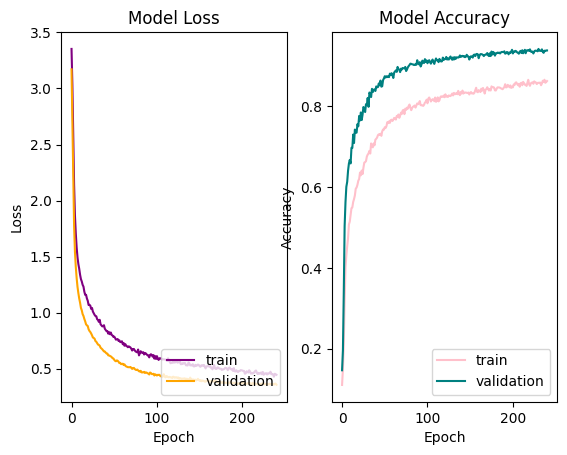

In [25]:
# plot the loss curve 
plt.subplot(1,2,1)
plt.plot(history_mlp0.history['loss'], color = 'purple')
plt.plot(history_mlp0.history['val_loss'], color = 'orange')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')

# plot the accuray curve 
plt.subplot(1,2,2)
plt.plot(history_mlp0.history['accuracy'], color = 'pink')
plt.plot(history_mlp0.history['val_accuracy'], color = 'teal')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')

plt.show()

### Evaluating test accuracy

In [26]:
# making predictions using the test dataset 
test_predict = mlp_base.predict(test_x)
# getting the labels from each predictions
test_predict_labels = [np.argmax(probs) for probs in test_predict]

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [27]:
# Calculate the testing accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_predict_labels, test_y)
print("accuracy score = ", accuracy*100, " %")

accuracy score =  93.82716049382715  %


<hr>

## Out-of- sample performance evaluation
Testing the model on an external dataset sample to evaluate the performance accurracy on real life samples
### Defining Preprocessing functions
`feature_extraction()` - to extract landmarks from pictures using the mediapipe framework  
`normalize_landmarks()` - normalize landmarks so that we can use the coordinates in the model

In [28]:
# method to extract landmarks from test samples
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

def feature_extraction(test_paths):
  test_landmarks = []
  with mp_hands.Hands(
      static_image_mode=True,
      max_num_hands=1,
      min_detection_confidence=0.1) as hands:
    for file in test_paths:
      # Read an image, flip it around y-axis for correct handedness output (see
      # above).
      image = cv2.flip(cv2.imread(file), 1)
      # Convert the BGR image to RGB before processing.
      results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      
      # Print handedness and draw hand landmarks on the image. (left or right)
      #print('Handedness:', results.multi_handedness)
      if not results.multi_hand_landmarks:
        #skipped_images.append(file)
        continue
      # image_height, image_width, _ = image.shape
      # annotated_image = image.copy()

      test_landmarks.append(results.multi_hand_landmarks)
  return test_landmarks

In [29]:
def normalize_landmarks(test_paths, test_landmarks):
    test_normalized_landmarks = []
    for path, landmark_list in zip(test_paths, test_landmarks):
        # print(path)
        # print(landmark_list[0])
        # for hand_landmarks in landmark_list[0]:
        normalized_landmarks = calc_landmark_list(cv2.imread(path), landmark_list[0])
        normalized_landmarks = pre_process_landmark(normalized_landmarks)
        test_normalized_landmarks.append(normalized_landmarks)
    return (test_normalized_landmarks)

In [30]:
# get the picture paths of the out of dataset samples
new_data_dir = 'out of sample/'
test_paths = os.listdir(new_data_dir)

# join directory path with image path
for i, path in enumerate(test_paths):
    test_paths[i] = os.path.join(new_data_dir, path)

In [31]:
# extract features 
test_landmarks = feature_extraction(test_paths)
# normalize landmarks 
test_normalized_landmarks = normalize_landmarks(test_paths, test_landmarks)

harf = mlp_base.predict(np.array(test_normalized_landmarks))
harf

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 


array([[2.4821969e-05, 1.4408926e-02, 1.5134229e-13, ..., 1.1223966e-12,
        9.2778841e-08, 2.2221410e-03],
       [2.4740250e-05, 1.6840091e-02, 9.5240168e-14, ..., 6.7777121e-13,
        8.6897401e-08, 2.3291465e-03],
       [8.8000024e-06, 7.0416784e-01, 1.2162522e-15, ..., 1.0181525e-16,
        5.5898632e-08, 5.0993962e-03],
       ...,
       [4.0857423e-05, 8.3722752e-15, 1.5609877e-01, ..., 3.6582926e-05,
        1.0248503e-06, 1.7907354e-19],
       [7.7720273e-08, 8.7316967e-15, 5.6046575e-01, ..., 2.0335827e-07,
        2.8091823e-05, 5.7250357e-18],
       [2.6791216e-07, 2.0469574e-26, 2.9427315e-07, ..., 1.7751419e-09,
        1.4602642e-09, 1.9955403e-10]], dtype=float32)

In [32]:
# get the labels from the probabilities
harf = [np.argmax(probs) for probs in harf]
print("letter index: ", harf)

letter index:  [21, 21, 1, 1, 1, 11, 11, 20, 12, 12, 19, 4, 19, 19, 19, 22, 22, 29, 22, 22, 28, 28, 15, 28, 15, 2, 2, 3, 3, 18, 10, 12, 8, 12, 12, 12, 2, 16, 7, 2, 8]


In [33]:
# get the letter from the letter guide using its index
predicted_letters = [Data_Alph.to_numpy()[letter] for letter in harf]
print(predicted_letters)

[array(['Sheen'], dtype=object), array(['Sheen'], dtype=object), array(['Al'], dtype=object), array(['Al'], dtype=object), array(['Al'], dtype=object), array(['Kaf'], dtype=object), array(['Kaf'], dtype=object), array(['Seen'], dtype=object), array(['Khah'], dtype=object), array(['Khah'], dtype=object), array(['Sad'], dtype=object), array(['Dad'], dtype=object), array(['Sad'], dtype=object), array(['Sad'], dtype=object), array(['Sad'], dtype=object), array(['Tah'], dtype=object), array(['Tah'], dtype=object), array(['Zah'], dtype=object), array(['Tah'], dtype=object), array(['Tah'], dtype=object), array(['Yeh'], dtype=object), array(['Yeh'], dtype=object), array(['Meem'], dtype=object), array(['Yeh'], dtype=object), array(['Meem'], dtype=object), array(['Alef'], dtype=object), array(['Alef'], dtype=object), array(['Beh'], dtype=object), array(['Beh'], dtype=object), array(['Reh'], dtype=object), array(['Jeem'], dtype=object), array(['Khah'], dtype=object), array(['Hah'], dtype=object),

In [34]:
test_paths

['out of sample/11_16_M_al_3.jpg',
 'out of sample/11_16_M_al_4.jpg',
 'out of sample/11_16_M_al_5.jpg',
 'out of sample/11_16_M_al_6.jpg',
 'out of sample/11_16_M_al_7.jpg',
 'out of sample/11_16_M_kaaf_6.jpg',
 'out of sample/11_16_M_kaaf_7.jpg',
 'out of sample/11_16_M_kaaf_8.jpg',
 'out of sample/11_16_M_khaa_0.jpg',
 'out of sample/11_16_M_khaa_1.jpg',
 'out of sample/11_16_M_saad_0.jpg',
 'out of sample/11_16_M_saad_1.jpg',
 'out of sample/11_16_M_saad_2.jpg',
 'out of sample/11_16_M_saad_3.jpg',
 'out of sample/11_16_M_saad_4.jpg',
 'out of sample/11_16_M_taa_4.jpg',
 'out of sample/11_16_M_taa_5.jpg',
 'out of sample/11_16_M_taa_6.jpg',
 'out of sample/11_16_M_taa_7.jpg',
 'out of sample/11_16_M_taa_8.jpg',
 'out of sample/11_16_M_yaa_3.jpg',
 'out of sample/11_16_M_yaa_4.jpg',
 'out of sample/11_16_M_yaa_5.jpg',
 'out of sample/11_16_M_yaa_6.jpg',
 'out of sample/11_16_M_yaa_7.jpg',
 'out of sample/12_22_F_aleff_7.jpg',
 'out of sample/12_22_F_aleff_8.jpg',
 'out of sample/12_

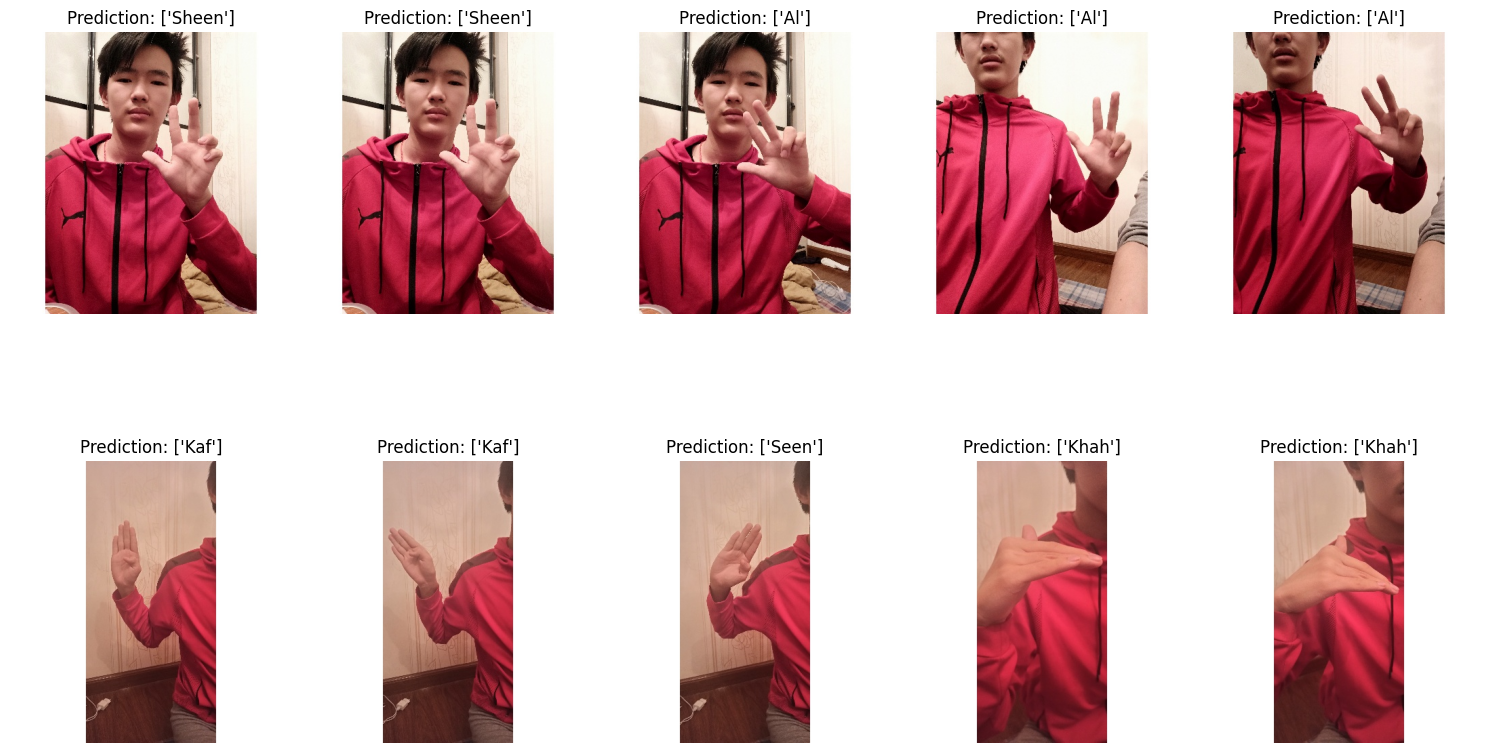

In [36]:
# plot some of the pictures with their label
out_imgs = [cv2.imread(image) for image in test_paths]

def plot_images_with_predictions(image_paths, predictions):
    # Check if we have exactly 10 images
    if len(image_paths) != 10 or len(predictions) != 10:
        print("Please provide exactly 10 image paths and predictions.")
        return

    plt.figure(figsize=(15, 10))  # Set the figure size for better visibility

    for i in range(10):
        img = cv2.imread(image_paths[i])  # Read the image
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting
        
        plt.subplot(2, 5, i + 1)  # Create a subplot (2 rows, 5 columns)
        plt.imshow(img_rgb)  # Display the image
        plt.title(f'Prediction: {predictions[i]}')  # Add prediction as the title
        plt.axis('off')  # Hide the axis for a cleaner look

    plt.tight_layout()  # Adjust the layout so that images do not overlap
    plt.show()  # Display the plot

plot_images_with_predictions(test_paths[:10], predicted_letters[:10])

### Model Structure 2
Adding more nodes in the hidden layers , an extra hidden, as well as adding an additional dropout layer

**The new Network Structure:**  
- Input layer
- 3 hidden layers:
    - 64 nodes in 1st layer
    - 48 nodes in 2nd and 3rd layer
- 1 Ouput layer: Softmax  

In [37]:
def mlp_model_1():
    model = Sequential()

    # 1st hidden layer: 64 nodes, relu
    model.add(Dense(64, activation = 'relu', input_shape = (input_shape[1],)))
    # dropout rate 0.4
    model.add(Dropout(0.4))
    # 2nd hidden layer: 48 nodes, relu
    model.add(Dense(48, activation = 'relu'))
    # dropout rate 0.2
    model.add(Dense(48, activation = 'relu'))
    # output layer
    model.add(Dense(output_shape, activation = 'softmax'))

    # define optimizer & learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
    # compile model and define loss function
    model.compile(optimizer=optimizer, loss= 'sparse_categorical_crossentropy', metrics = ['accuracy'])

    return model

In [38]:
# instantiate the model 
mlp_model1 = mlp_model_1()
mlp_model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 48)             │         3,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 31)             │         1,519 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,743 (38.06 KB)

 Trainable params: 9,743 (38.06 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# define early stopping
early_stopping = EarlyStopping(patience = 20, verbose = 1)
# train the model
history_mlp1 = mlp_model1.fit(train_x, train_y, epochs=1000, validation_data=(test_x, test_y), callbacks=early_stopping)

Epoch 1/1000
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1051 - loss: 3.2527 - val_accuracy: 0.3478 - val_loss: 2.2166
Epoch 2/1000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3398 - loss: 2.1202 - val_accuracy: 0.6065 - val_loss: 1.2837
Epoch 3/1000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5054 - loss: 1.4246 - val_accuracy: 0.7069 - val_loss: 0.9625
Epoch 4/1000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6103 - loss: 1.1391 - val_accuracy: 0.7617 - val_loss: 0.8187
Epoch 5/1000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6265 - loss: 1.0226 - val_accuracy: 0.7917 - val_loss: 0.7337
Epoch 6/1000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6534 - loss: 0.9849 - val_accuracy: 0.7998 - val_loss: 0.6574
Epoch 7/1000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6873 - loss: 0.8556 - val_accuracy: 0.8341 - val_loss: 0.5957
Epoch 8/1000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7128 - loss: 0.8122 - 

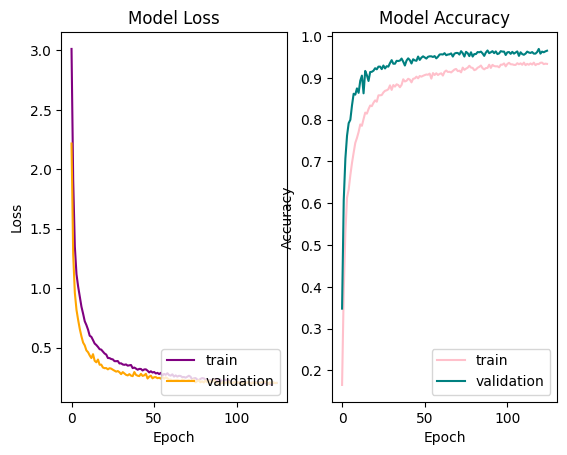

In [40]:
# plot the loss curve 
plt.subplot(1,2,1)
plt.plot(history_mlp1.history['loss'], color = 'purple')
plt.plot(history_mlp1.history['val_loss'], color = 'orange')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')

# plot the accuray curve 
plt.subplot(1,2,2)
plt.plot(history_mlp1.history['accuracy'], color = 'pink')
plt.plot(history_mlp1.history['val_accuracy'], color = 'teal')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')

plt.show()

### Evaluating test accuracy

In [41]:
# making predictions using the test dataset 
test_predict = mlp_model1.predict(test_x)
# getting the labels from each predictions
test_predict_labels = [np.argmax(probs) for probs in test_predict]

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [42]:
# Calculate the testing accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_predict_labels, test_y)
print("accuracy score = ", accuracy*100, " %")

accuracy score =  96.51100375738056  %


## Out-of- sample performance evaluation
Testing the model on an external dataset sample to evaluate the performance accurracy on real life samples
### Defining Preprocessing functions
`feature_extraction()` - to extract landmarks from pictures using the mediapipe framework  
`normalize_landmarks()` - normalize landmarks so that we can use the coordinates in the model

In [43]:
# method to extract landmarks from test samples
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

def feature_extraction(test_paths):
  test_landmarks = []
  with mp_hands.Hands(
      static_image_mode=True,
      max_num_hands=1,
      min_detection_confidence=0.1) as hands:
    for file in test_paths:
      # Read an image, flip it around y-axis for correct handedness output (see
      # above).
      image = cv2.flip(cv2.imread(file), 1)
      # Convert the BGR image to RGB before processing.
      results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      
      # Print handedness and draw hand landmarks on the image. (left or right)
      #print('Handedness:', results.multi_handedness)
      if not results.multi_hand_landmarks:
        #skipped_images.append(file)
        continue
      # image_height, image_width, _ = image.shape
      # annotated_image = image.copy()

      test_landmarks.append(results.multi_hand_landmarks)
  return test_landmarks

In [44]:
def normalize_landmarks(test_paths, test_landmarks):
    test_normalized_landmarks = []
    for path, landmark_list in zip(test_paths, test_landmarks):
        # print(path)
        # print(landmark_list[0])
        # for hand_landmarks in landmark_list[0]:
        normalized_landmarks = calc_landmark_list(cv2.imread(path), landmark_list[0])
        normalized_landmarks = pre_process_landmark(normalized_landmarks)
        test_normalized_landmarks.append(normalized_landmarks)
    return (test_normalized_landmarks)

#### Helper function to plot 10 pics at a time with predicted label and true label 

In [45]:
def plot_images_with_predictions(image_paths, predictions):
    # Check if we have exactly 10 images
    if len(image_paths) != 10 or len(predictions) != 10:
        print("Please provide exactly 10 image paths and predictions.")
        return

    plt.figure(figsize=(15, 10))  # Set the figure size for better visibility

    for i in range(10):
        img = cv2.imread(image_paths[i])  # Read the image
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting
        
        # get the true label of the image 
        # snippet speicific to the naming convention of this dataset only
        # split filepath by _
        path = image_paths[i].split("_")
        # get the letter name - the token next to last
        true_letter = path[3]

        plt.subplot(2, 5, i + 1)  # Create a subplot (2 rows, 5 columns)
        plt.imshow(img_rgb)  # Display the image
        plt.title(f'Prediction: {predictions[i]}\nTrue label: {true_letter}')  # Add prediction as the title
        plt.axis('off')  # Hide the axis for a cleaner look

    plt.tight_layout()  # Adjust the layout so that images do not overlap
    plt.show()  # Display the plot

### Getting the new data ready for prediction

In [46]:
# get the picture paths of the out of dataset samples
new_data_dir = 'out of sample/'
test_paths = os.listdir(new_data_dir)

# join directory path with image path
for i, path in enumerate(test_paths):
    test_paths[i] = os.path.join(new_data_dir, path)

In [47]:
# extract features 
test_landmarks = feature_extraction(test_paths)
# normalize landmarks 
test_normalized_landmarks = normalize_landmarks(test_paths, test_landmarks)

harf = mlp_model1.predict(np.array(test_normalized_landmarks))
harf

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


array([[4.3250725e-10, 7.2803134e-01, 2.8575534e-10, ..., 1.1836844e-09,
        4.4171407e-12, 4.2307374e-06],
       [3.6427555e-10, 7.6024479e-01, 2.8147260e-10, ..., 1.0364427e-09,
        3.8105730e-12, 3.7600780e-06],
       [6.3154726e-09, 8.8571692e-01, 1.2141929e-11, ..., 4.2325855e-11,
        7.6937978e-10, 2.6597418e-03],
       ...,
       [9.7910240e-09, 1.8302742e-13, 4.9349886e-01, ..., 4.7215968e-04,
        2.2627974e-08, 4.2537741e-15],
       [7.6826964e-08, 8.8300146e-13, 3.1646100e-04, ..., 2.0092761e-04,
        2.7893400e-06, 1.1183505e-14],
       [1.3844270e-07, 1.0234886e-20, 2.7709262e-07, ..., 1.6397040e-11,
        2.8341459e-13, 1.8673738e-09]], dtype=float32)

In [48]:
# get the labels from the probabilities
harf = [np.argmax(probs) for probs in harf]
print("letter index: ", harf)

letter index:  [1, 1, 1, 1, 1, 11, 10, 11, 12, 12, 19, 4, 19, 19, 19, 29, 22, 29, 22, 22, 15, 15, 28, 15, 15, 2, 2, 3, 3, 3, 8, 12, 8, 12, 12, 8, 7, 16, 2, 7, 8]


In [49]:
# get the letter from the letter guide using its index
predicted_letters = [Data_Alph.to_numpy()[letter] for letter in harf]
print(predicted_letters)

[array(['Al'], dtype=object), array(['Al'], dtype=object), array(['Al'], dtype=object), array(['Al'], dtype=object), array(['Al'], dtype=object), array(['Kaf'], dtype=object), array(['Jeem'], dtype=object), array(['Kaf'], dtype=object), array(['Khah'], dtype=object), array(['Khah'], dtype=object), array(['Sad'], dtype=object), array(['Dad'], dtype=object), array(['Sad'], dtype=object), array(['Sad'], dtype=object), array(['Sad'], dtype=object), array(['Zah'], dtype=object), array(['Tah'], dtype=object), array(['Zah'], dtype=object), array(['Tah'], dtype=object), array(['Tah'], dtype=object), array(['Meem'], dtype=object), array(['Meem'], dtype=object), array(['Yeh'], dtype=object), array(['Meem'], dtype=object), array(['Meem'], dtype=object), array(['Alef'], dtype=object), array(['Alef'], dtype=object), array(['Beh'], dtype=object), array(['Beh'], dtype=object), array(['Beh'], dtype=object), array(['Hah'], dtype=object), array(['Khah'], dtype=object), array(['Hah'], dtype=object), arra

In [50]:
test_paths

['out of sample/11_16_M_al_3.jpg',
 'out of sample/11_16_M_al_4.jpg',
 'out of sample/11_16_M_al_5.jpg',
 'out of sample/11_16_M_al_6.jpg',
 'out of sample/11_16_M_al_7.jpg',
 'out of sample/11_16_M_kaaf_6.jpg',
 'out of sample/11_16_M_kaaf_7.jpg',
 'out of sample/11_16_M_kaaf_8.jpg',
 'out of sample/11_16_M_khaa_0.jpg',
 'out of sample/11_16_M_khaa_1.jpg',
 'out of sample/11_16_M_saad_0.jpg',
 'out of sample/11_16_M_saad_1.jpg',
 'out of sample/11_16_M_saad_2.jpg',
 'out of sample/11_16_M_saad_3.jpg',
 'out of sample/11_16_M_saad_4.jpg',
 'out of sample/11_16_M_taa_4.jpg',
 'out of sample/11_16_M_taa_5.jpg',
 'out of sample/11_16_M_taa_6.jpg',
 'out of sample/11_16_M_taa_7.jpg',
 'out of sample/11_16_M_taa_8.jpg',
 'out of sample/11_16_M_yaa_3.jpg',
 'out of sample/11_16_M_yaa_4.jpg',
 'out of sample/11_16_M_yaa_5.jpg',
 'out of sample/11_16_M_yaa_6.jpg',
 'out of sample/11_16_M_yaa_7.jpg',
 'out of sample/12_22_F_aleff_7.jpg',
 'out of sample/12_22_F_aleff_8.jpg',
 'out of sample/12_

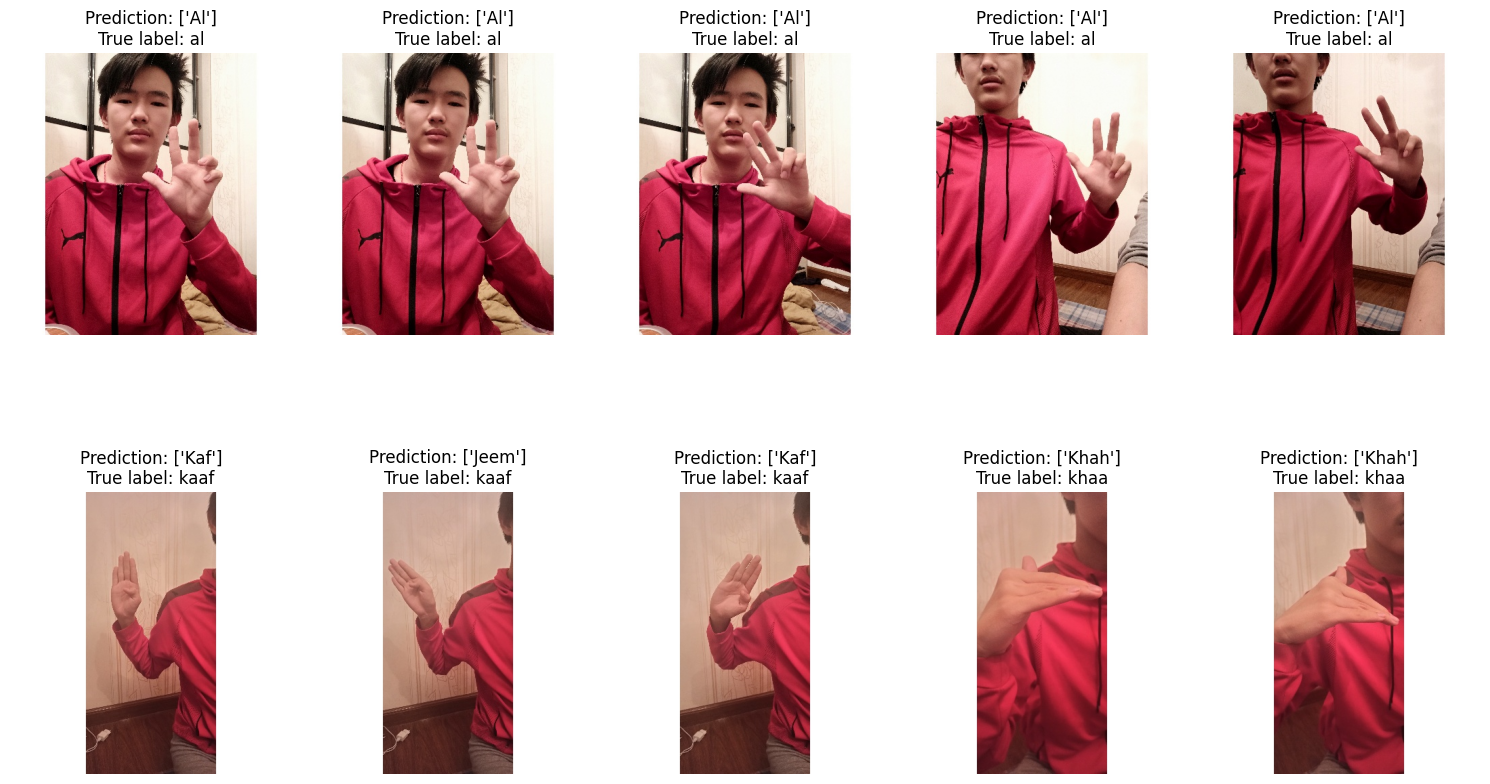

In [51]:
# plot some of the pictures with their label
out_imgs = [cv2.imread(image) for image in test_paths]
plot_images_with_predictions(test_paths[:10], predicted_letters[:10])

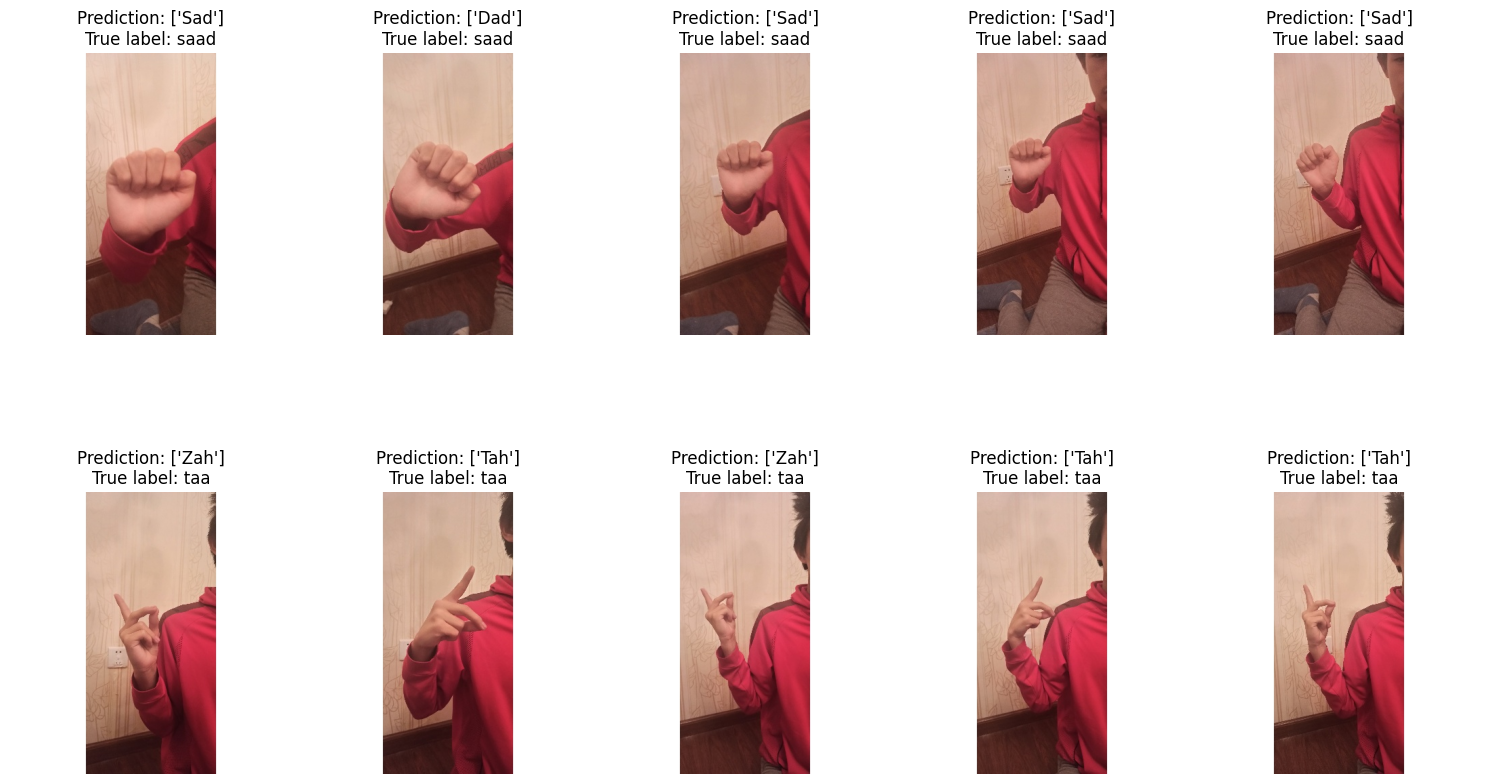

In [52]:
plot_images_with_predictions(test_paths[10:20], predicted_letters[10:20])

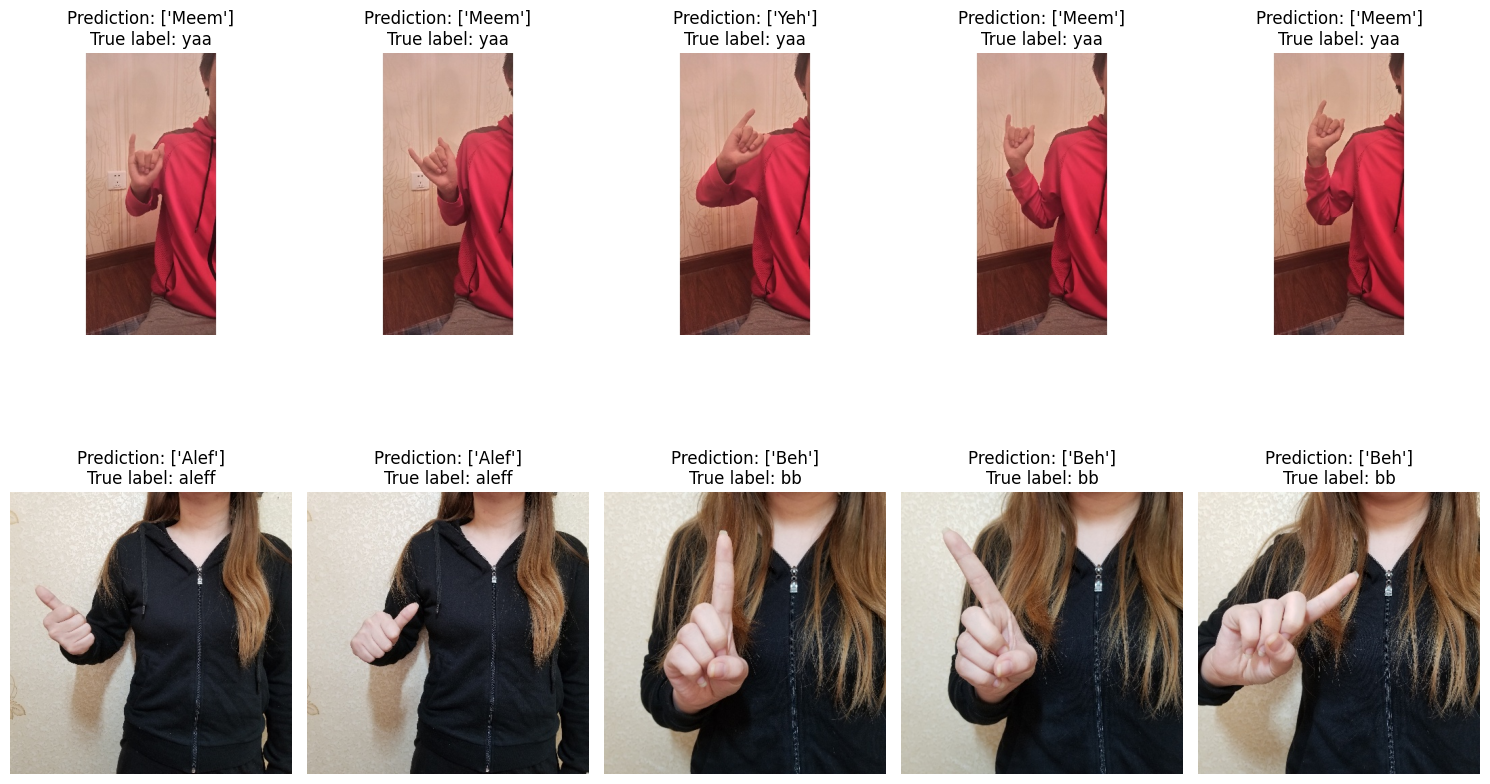

In [53]:
plot_images_with_predictions(test_paths[20:30], predicted_letters[20:30])

<hr>

In [54]:
mlp_model1.save("mlp_model1.h5")